# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель исследования** — <u>Построить модель, которая по фотографии определит приблизительный возраст человека (значение MAE на тестовой должно быть не больше 8).</u>

В нашем распоряжении набор фотографий людей  с указанием возраста. **Исследование пройдет в 4 основных этапа:**
1. Исследовательский анализ данных.
2. Обучение модели.
3. Анализ обученной модели.
4. Вывод.

## Исследовательский анализ данных

In [1]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
import scipy.stats as stats
import pylab 

import skimage 
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

display(labels.head())
display(labels.info())
display(labels.describe())
print('Количество уникальных файлов:',labels['file_name'].value_counts().sum())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Количество уникальных файлов: 7591


In [4]:
# сгенерируем батчи с фотографиями и метками классов

path = '/datasets/faces/final_files/'

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=24,
        class_mode='raw', # sparse 
        seed=12345)

Found 7591 validated image filenames.


In [5]:
# посмотрим на размеры изображений

filelist = os.listdir(path)

first_img = skimage.io.imread(os.path.join(path, filelist[0]))
second_img = skimage.io.imread(os.path.join(path, filelist[1]))
last_img = skimage.io.imread(os.path.join(path, filelist[-1]))

print(first_img.shape)
print(second_img.shape)
last_img.shape

(787, 787, 3)
(462, 462, 3)


(635, 635, 3)

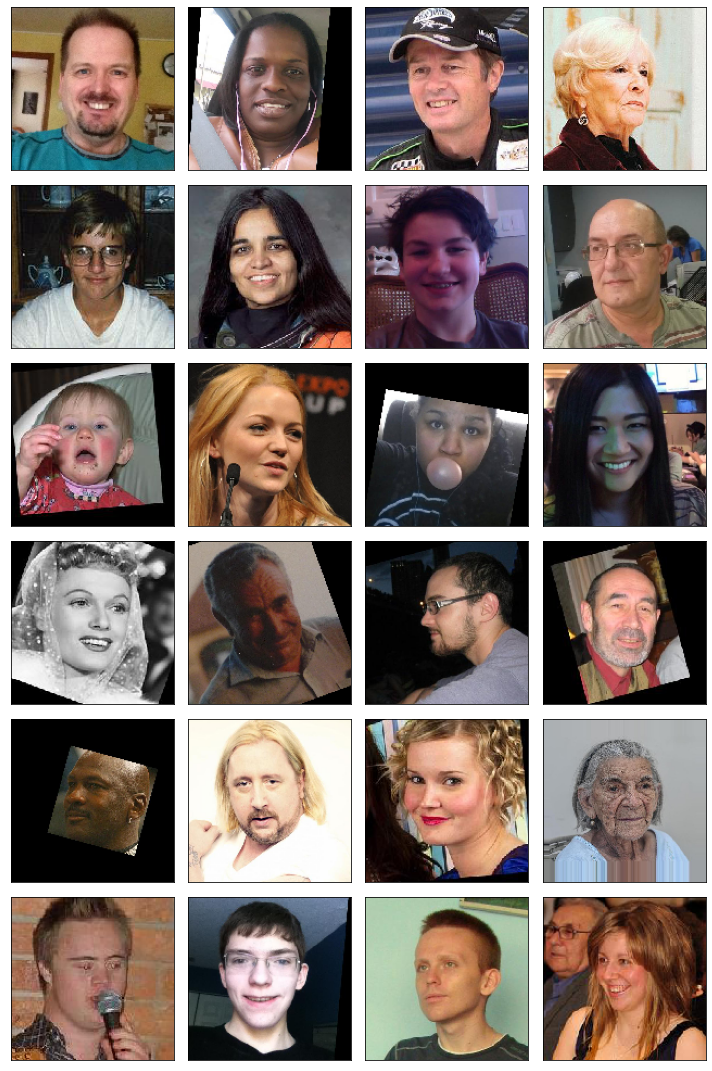

In [6]:
features, target = next(datagen_flow)

# выведем 24 изображения
fig = plt.figure(figsize=(10,15))
for i in range(24):
    fig.add_subplot(6, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [7]:
# разобьем на условные возрастные категории

cat_labels = labels.copy()

cat_labels.loc[cat_labels['real_age']<=2, 'age_group'] = 'babies (<2)'
cat_labels.loc[cat_labels['real_age'].between(2,13), 'age_group'] = 'children (2-13)'
cat_labels.loc[cat_labels['real_age'].between(14,17), 'age_group'] = 'adolescens (14-17)'
cat_labels.loc[cat_labels['real_age'].between(18,39), 'age_group'] = 'young adults (18-39)'
cat_labels.loc[cat_labels['real_age'].between(40,59), 'age_group'] = 'middle-aged adults (40-59)'
cat_labels.loc[cat_labels['real_age'].between(60,89), 'age_group'] = 'old adults (60-89)'
cat_labels.loc[cat_labels['real_age']>=90, 'age_group'] = 'long-livers (90+)'

cat_labels.head()

,file_name,real_age,age_group
0,000000.jpg,4,children (2-13)
1,000001.jpg,18,young adults (18-39)
2,000002.jpg,80,old adults (60-89)
3,000003.jpg,50,middle-aged adults (40-59)
4,000004.jpg,17,adolescens (14-17)


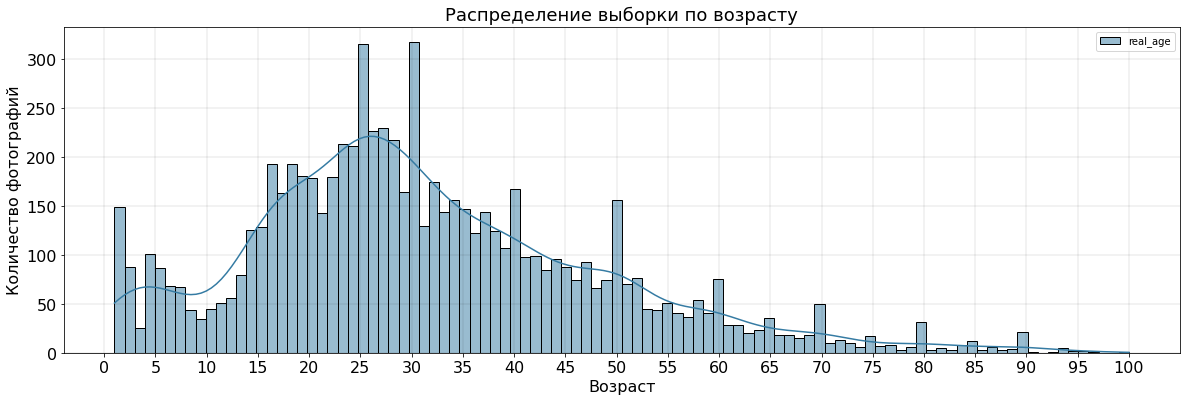

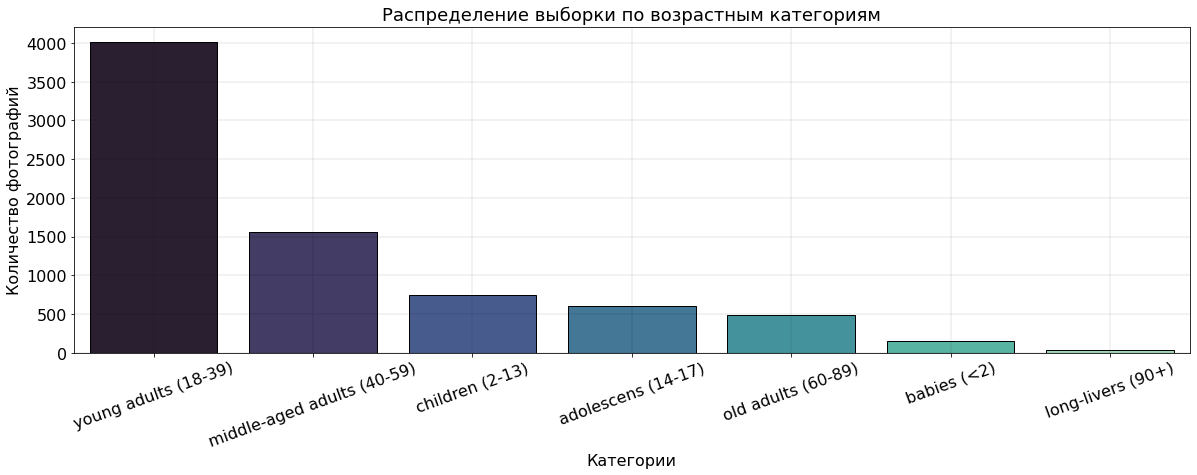

In [8]:
# посмотрим на распределение фотографий по возрасту людей

plt.figure(figsize=(20,6))
ax = sns.histplot(labels, palette='mako', kde=True, bins=100)

plt.title('Распределение выборки по возрасту', fontsize=18)
plt.xlabel('Возраст', fontsize=16)
plt.ylabel('Количество фотографий',fontsize=16)
plt.grid(linestyle='-', linewidth='0.1', color='black')
ax.set_xticks(np.arange(0, labels['real_age'].max()+1, 5))
plt.tick_params(labelsize = 16)
plt.show()


# по возрастным категориям

cat_labels = cat_labels.pivot_table(index='age_group', values = 'real_age', 
                                   aggfunc = 'count').sort_values(by = 'real_age', ascending = False)
print()
plt.figure(figsize=(20,6))
sns.barplot(x = cat_labels.index, y = list(chain.from_iterable(cat_labels.values.tolist())), 
            palette = 'mako', edgecolor ='black')

plt.title('Распределение выборки по возрастным категориям', fontsize=18)
plt.xlabel('Категории', fontsize=16)
plt.ylabel('Количество фотографий',fontsize=16)
plt.grid(linestyle='-', linewidth='0.1', color='black')
plt.tick_params(labelsize = 16)
plt.xticks(rotation=20)    
plt.show()

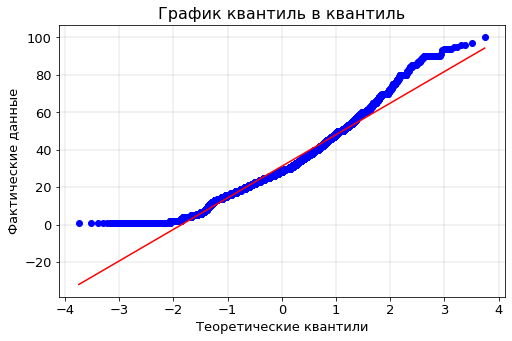

In [9]:
plt.figure(figsize=(8,5))
stats.probplot(labels['real_age'], dist="norm", plot=pylab)

plt.title('График квантиль в квантиль', fontsize=16)
plt.xlabel('Теоретические квантили', fontsize=13)
plt.ylabel('Фактические данные',fontsize=13)
plt.grid(linestyle='-', linewidth='0.1', color='black')
ax.set_xticks(np.arange(0, labels['real_age'].max()+1, 5))
plt.tick_params(labelsize = 13)
plt.show()

pylab.show()

## Вывод


В представленном датасете 7591 фотография людей с размеченными возрастами от года до 100 лет. 
Средний возраст - 31 год, медианный - 29 лет. В выборке преимущественно представлены фотографии людей 18-40 лет (чуть больше половины), за ними следует условная возрастная категория `"middle-aged adults"` - от 40 до 60 лет - около 20%. Самые немногочисленные категориии - "младенцы" (всего 149 изображений) и "долгожители" (34), вместе фотографии людей этих возрастных категорий составляют менее процента от нашей выборки.

Распределение похоже на нормальное, однако можно наблюдать всплески в начале: большое количество фотографий с грудничками и детьми до 9 лет. Также видим вытянутый правый хвост.

Если говорить про сами изображения, они неоднородны имеют разную размерность. 
Значительная часть фотографий обрезана, наклонена и сдвинута от центра на черном фоне. Это говорит нам о том, что аугментация, скорее всего, уже была проведена. 
Также представлен разный ракурс, разное освещение. Лица многих людей прикрывают различные объекты, например, очки, микрофон, челка, головные уборы, жевательная резинка и т.д. Кажется, что все это должно только положительно сказаться на качестве модели (хоть и замедлить ее обучение), так как фотографии из данной выборки приближены к реальным условиям, в которых в дальнейшем будт работать модель: покупатели супермаркета «Хлеб-Соль» в в прикассовой зоне вряд ли заметят камеру и, тем более не будут позировать в объектив "как на паспор". Их лица могут быть зафиксированы в разных положениях, по-разному может падать свет, не исключено наличие головных уборов и различных объектов, прикрывающих лицо.

Учитывая распределение возрастных категорий в выборке, с большей вероятностью модель верно определит возраст человека от 18 до 40 лет. 

## Обучение модели

### Код

In [11]:
'''
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs//2,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model
'''

"\nimport pandas as pd\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nfrom tensorflow.keras.applications.resnet import ResNet50\nfrom tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.optimizers import Adam\n \n \ndef load_train(path):\n    labels = pd.read_csv(path + 'labels.csv')\n    train_datagen = ImageDataGenerator(\n        validation_split=0.25,\n        horizontal_flip=True,\n        rescale=1./255)\n    train_gen_flow = train_datagen.flow_from_dataframe(\n        dataframe=labels,\n        directory=path + 'final_files/',\n        x_col='file_name',\n        y_col='real_age',\n        target_size=(224, 224),\n        batch_size=16,\n        class_mode='raw',\n        subset='training',\n        seed=12345)\n \n    return train_gen_flow\n \ndef load_test(path):\n    labels = pd.read_csv(path + 'labels.csv')\n    test_datagen = ImageDataGenerator(\n        

### Результат

## Анализ обученной модели

В кажестве архитектуры сверточной нейронной сети мы использовали ResNet50. 
Мы провели обучение в 2 этапа: сначала проводим 20 эпох с шагом обучения = 0.0005 и "дотюнинговываем", задав новый оптимизатор меньший в 5 раз, сохраняя функцию потерь и  метрику, обучаем снова на 10 эпохах.
Таким образом, получили среднее абсолютное отклонение ≈ 6.

## Вывод

Мы изучили датасет из 7591 фотографии разной людей с размеченными возрастами от года до 100 лет. Данных немного, но достаточно для обучения модели. Средний возраст человека на фотографии - 31 год, половину выборки составляют фотографии людей от 18 до 40 лет. Самые малочисленные категории - "младенцы (до 2ух лет)"  и "долгожители (90+)". Долгожители с маленькой вероятность станут покупателями супермаркета, однако, младенцы, зафиксированные на фото, позволят супермаркету предложить их родителям ряд товаров для малышей.

Предоставленные изображения отлично подходят для обучения модели: разное освещение, ракурсы, предметы, прикрывающие лицо (очки, головные уборы и т.д.) приближают выборку к тем фотографиям, которые будут сделаны в прикассовой зоне супермаркета, что должно положительно сказаться на качестве модели "в бою".

Обученная нами нейронная сеть с архитектурой ResNet50 в среднем ошибается на 6 лет. Это отличный результат, если говорить про первую цель супермаркета «Хлеб-Соль»: *Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы*, так как обычно возрастные группы определяются с шагом 20+ лет. 

К сожалению, мы не можем утверждать, что данная модель справится так же хорошо со второй целью команды супермаркета: *Контроль добросовестности кассиров при продаже алкоголя*, например, если алкоголь будет продан подростку 12-17 лет, чей возраст будет ошибочно завышен. Предлагая наше решение супермаркету «Хлеб-Соль», стоит обратить внимание на то, что при контроле кассиров не стоит полностью доверять данной модели.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы